1. Read all the TSV files into an array, write a function to extract the title and authors data
2. Go through each TSV and use title and authors to search the OCLC for OWI number
3. Go through each OWI and get:
    3.1 Earliest year published
    3.2 Holdings
    3.3 For OWI with the most holdings: VIAF -> Genders
    3.5 For each OWI where "book" in .get("format")
    Make Genders -> DDC dict, add to it manually
4. Make a dict of TITLE/AUTHOR STRING -> OWI, YEAR_PUBLISHED, GENDER(S), TOP_DDC, FAST_LIST?

In [1]:
import csv, os
from datetime import datetime
f_filen = "tabula-1963-03-17.tsv"
nf_filen = "tabula-1963-03-17-nf.tsv"
data_i = 2 #How far into the tsv file the data shows up...
fields = ['rank','title+author','rank_last_week','weeks_on_list']
stop_words_authors = ["Others"]

# Read the Data In

In [2]:
def empty(row):
    if row[0]=="":
        return True
    return False 

def extract_date(datestr):
    try:
        date = datetime.strptime(datestr[0],'%B %d, %Y')
    except ValueError:
        try:
            date = datetime.strptime(datestr[0],'%B %d,%Y')
        except ValueError:
            print datestr
            datestr = raw_input("Enter the date in %B %d, %Y format: ")
            date = datetime.strptime(datestr,'%B %d, %Y')
    return date

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def header(row):
    if is_number(row[0]):
        return False
    else:
        return True
    
def read_tsv(name):
    i = 0
    arr = []
    date = ""
    with open(name) as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        for row in reader:
            if (not empty(row)):
                if (header(row)) & (i>data_i):
                    return arr
                if i==0:
                    date_field = [row[1]]
                    if row[1] == "":
                        date_field = [row[2]]
                    date = extract_date(date_field)
                if (i > data_i):
                    arr.append([date]+row)
                i = i+1
        return arr
    
def read_folder(folderpath):
    arr = []
    for f in os.listdir(folderpath):
        commasv = read_tsv(folderpath+f)
        arr = arr+commasv
    return arr

eighty_path = "tsvs/1980s/"
eighties = read_folder(eighty_path)
seventies_path = "tsvs/1970s/"
seventies = read_folder(seventies_path)
sixties_path = "tsvs/1960s/"
sixties = read_folder(sixties_path)
fifties_path = "tsvs/1950s/"
fifties = read_folder(fifties_path)

for x in fifties[0:10]:
    print x
    
    
to_process = fifties + sixties + seventies + eighties
print len(fifties+sixties+seventies+eighties)

[datetime.datetime(1953, 4, 19, 0, 0), '2', 'THE SILVER CHALICE, by Thomas B. Costain.', '2', '38']
[datetime.datetime(1953, 4, 19, 0, 0), '3', 'GOLDEN ADMIRAL, by Francis Van Wyck Mason.', '3', '7']
[datetime.datetime(1953, 4, 19, 0, 0), '4', 'STEAMBOAT GOTHIC, by Frances Parkinson Keyes.', '5', '21']
[datetime.datetime(1953, 4, 19, 0, 0), '5', 'EAST OF EDEN, by John Steinbeck.', '4', '29']
[datetime.datetime(1953, 4, 19, 0, 0), '6', 'KISS ME AGAIN, STRANGER, by Daphne du Maurier.', '8', '4']
[datetime.datetime(1953, 4, 19, 0, 0), '7', 'THE CAINE MUTINY, by Herman Wouk.', '7', '105']
[datetime.datetime(1953, 4, 19, 0, 0), '8', 'THE SECOND HAPPIEST DAY, by John Phillips.', '6', '10']
[datetime.datetime(1953, 4, 19, 0, 0), '9', 'PRINCE BART, by Jay Richard Kennedy.', '9', '4']
[datetime.datetime(1953, 4, 19, 0, 0), '10', 'THE SOJOURNER, by Marjorie Kinnan Rawlings.', '11', '14']
[datetime.datetime(1953, 4, 19, 0, 0), '11', 'THE GALILEANS, by Frank G. Slaughter.', '10', '12']
25608


# Get Title and Author

In [3]:
skip_these = set()

In [25]:
auth_i = 4

# strip trailing char if '.' or ' '
def strip_trailing_punct(a):
    last_char = a[len(a)-1]
    if (last_char != '.') & (last_char != ' '):
        return a
    b = a[:len(a)-1] 
    return strip_trailing_punct(b)


def parse_author_phrase(a_ph):
    authors = []
    end = len(a_ph)
    parens = a_ph.find("(")
    if parens != -1:
        end = parens-1
    auth_ph = a_ph[auth_i:end]
    if " and " in auth_ph:
        author_arr = auth_ph.split(" and ")
        for author in author_arr:
            author = strip_trailing_punct(author)
            if author not in stop_words_authors:
                authors.append(author)
    else:
        author = auth_ph
        author = strip_trailing_punct(author)
        authors.append(author)
    return authors

def title_author_pair(data_str):
    split_str = data_str.split(',')
    title = ""
    auth_ph = ""
    i=0
    t=True
    for phrase in split_str:    
        if i == 0:
            title = phrase
        else:
            if phrase.isupper() & t:
                title = title + ", "+phrase
            else:
                t = False
                auth_ph = auth_ph+phrase
        i = i+1
    try:
        authors = parse_author_phrase(auth_ph)
        if authors == []:
            authors = [data_str]
    except:
        skip_these.add(data_str)
        authors = [data_str]
    return (title,authors)

unique = unique_titles(processed)

print len(unique)

i = 0
for x in unique:
    if i > 10:
        break
    print x
    i = i+1

1894

YOUNGBLOOD HAWKE
THE HONEY BADGER
MOONFLEET, by John Meade Falkner.
THE ROOTS OF HEAVEN
THE CHESS PLAYERS
OUR MAN IN HAVANA
DREAMS DIE FIRST
WHIP HAND
WORLD CRUISE
SINS OF THE FATHERS


In [5]:
print title_author_pair("THE LAST HURRAH, by Margaret Attenbourough. (gestated in utero.)")

('THE LAST HURRAH', ['Margaret Attenbourough'])


# To OCLC


In [6]:
import xml.etree.ElementTree
import json,pickle
import urllib2
import re

oclc_base = "http://classify.oclc.org/classify2/Classify?"
alph = re.compile('[^a-zA-Z]')
suffixes = ['CPA', 'CSC', 'CSJ', 'DC', 'DD', 'DDS', 'DMD', 'DO', 'DVM', 'EDD', 'ESQ', 'II', 'III', 
            'IV', 'INC', 'JD', 'JR', 'LLD', 'LTD', 'MD', 'OD', 'OSB', 'PC', 'PE', 'PHD', 'RET', 
            'RGS', 'RN', 'RNC', 'SHCJ', 'SJ', 'SNJM', 'SR', 'SSMO', 'USA', 'USAF', 'USAFR', 'USAR', 
            'USCG', 'USMC', 'USMCR', 'USN', 'USNR']

In [7]:
def write_obj(obj,filename):
    with open(filename, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_obj(filename):
    with open(filename, 'rb') as handle:
        b = pickle.load(handle)
        return b
    
ta_to_data_dict = load_obj("rock_and_roll.pickle") 

In [8]:
def suffix(phrase):
    norm_phrase = phrase.replace(',',"").upper()
    if norm_phrase in suffixes:
        return True
    else:
        return False
    
def strip_punct(text):
    return alph.sub('', text)

def norm_text(text):
    return strip_punct(text).lower()

def url_to_data(url,f):
    req = urllib2.Request(url)
    req.add_header('User-agent', 'Mozilla 5.10')
    res = urllib2.urlopen(req)
    if(f=="xml"):
        data = xml.etree.ElementTree.parse(res).getroot()
    if(f=="json"):
        data = json.load(res)
    return data

def convert_to_search(name):
    return_string = ""
    last_ch = " "
    for ch in name:
        if (ch == " "):
            if (last_ch != "."):
                return_string = return_string + "+"
        else:
            if ch == ".":
                return_string = return_string +".+"
            else:
                return_string = return_string+ch
        last_ch = ch
    return return_string

def last_name_recursive(name,last_index):
    if last_index == 0:
        return ""
    last_phrase = name[last_index]
    if not suffix(last_phrase):
        return last_phrase
    else:
        return last_name_recursive(name, last_index-1)

def last_name(name):
    names = name.split(" ")
    last_index = len(names)-1
    last = last_name_recursive(names,last_index)
    return last

def first_name(name):
    names = name.split(" ")
    return names[0]

In [9]:
from lxml import html
from bs4 import BeautifulSoup
import requests

viaf_base = "http://www.viaf.org/viaf/"
    
def get_gender_scrape(i):
    url = viaf_base+str(i)+"/"
    data = requests.get(url).text
    soup = BeautifulSoup(data,"lxml")
    personal = soup.find('div',{'id':'personalinfo'})
    if personal is None:
        return ""
    h4s = personal.find('h4')
    if (h4s is None) or (len(h4s)<5):
        return ""
    mt = []
    i=0
    for h in h4s:
        mt.append(h)
        i = i+1
    return str(mt[4])

In [10]:
def is_book(w,t,a):
    if "book" in norm_text(w.get("format")):
        if norm_text(t) in norm_text(w.get("title")):
            for auth in a:
                if last_name(norm_text(auth)) in norm_text(w.get("author")):
                    return True
    return False

def find_all_works(xml,title,authors):
    works = xml.find('{http://classify.oclc.org}works')
#    print works
    if works is None:
        works = []
        works.append(xml.find('{http://classify.oclc.org}work'))
#        print works
        if (works is None) or works == []:
            return []        
    books = []
    for w in works:
        if is_book(w,title,authors):
            owi = w.get("owi")
            holdings = w.get("holdings")
            try:
                lyr = w.get("lyr")
            except:
                lyr = ""
            books.append({"owi":owi,"holdings":holdings,"lyr":lyr})
    return books

def new_work(w, entries):
    if int(w['holdings']) < 50:
        return False
    for e in entries:
        if w['owi'] == e["owi"]:
             return False
    return True

def get_oclc_entries(title,authors):
    url = oclc_base +"title="+convert_to_search(title)
    #i = 0
    entries = []
    for a in authors:
        auth_url = url +"&author=" + last_name(a)
#        print auth_url
        xml = url_to_data(auth_url,"xml")
#        print xml
        try:
            works = find_all_works(xml,title,authors)
        except:
            return []
        if works is None:
            return []
        if entries == []:
            entries = works
        else:
            for w in works:
                if new_work(w,entries):
                    entries.append(w)
        #i = i+1
    return entries
    
print get_oclc_entries('BELOVED', ['Toni Morrison']) 
print get_oclc_entries('SEVEN DAYS IN MAY', ['Fletcher Knebel']) 

def max_holding(oarr):
    target = oarr[0]
    for o in oarr[1:]:
        if int(o['holdings'])>int(target['holdings']):
            target = o
    return target

def get_authors(xml):
#    print xml
    authors = xml.find('{http://classify.oclc.org}authors')
#    print authors
    target = []
    for a in authors:
        text = a.text
        v = a.get('viaf')
        target.append({'name':text, 'viaf':v})
    return target

def get_fast(xml):
    recs = xml.find('{http://classify.oclc.org}recommendations')
    target = []
    if recs is not None:
        fast = recs.find('{http://classify.oclc.org}fast')
        if fast is not None:
            headings = fast.find('{http://classify.oclc.org}headings')
            for h in headings:
                target.append(h.text)
    return target

def lookup_oclc(owi):
    url = oclc_base+"owi="+owi
    xml = url_to_data(url,"xml")
    try:
        v = get_authors(xml)
    except:
        print url
        print xml
        response_code = xml.find('{http://classify.oclc.org}response').get("code")
        if response_code == '102':
            print '102!'
    fast = get_fast(xml)
    target = {'authors':v,'fast':fast}
    return target

test_author_dict = [{'viaf': '22619695', 'name': 'Bailey, Charles Waldo, 1929-2012 [Author]'}, {'viaf': '19720195', 'name': 'Knebel, Fletcher'}]

def get_genders(authors, viaf_dict):
    target = []
    for a in authors:
        v = get_viaf(a,viaf_dict)
        gender = get_gender_scrape(v)
        target.append({"name":a,"viaf":v,"gender":gender})
    return target
    
def get_viaf(author, viaf_dict_arr):
    l = norm_text(last_name(author))
    f = norm_text(first_name(author))
    target = ""
    for v in viaf_dict_arr:
        if l in norm_text(v['name']):
            target = v['viaf']
            if f in norm_text(v['name']):
                return v['viaf']
    return target

#print(get_genders(["Fletcher Knebel","Charles W. Bailey II"],test_author_dict))


[{'holdings': '13357', 'owi': '989794', 'lyr': '1987'}, {'holdings': '1899', 'owi': '149526417', 'lyr': '1987'}, {'holdings': '982', 'owi': '3768430774', 'lyr': '1998'}, {'holdings': '159', 'owi': '839489420', 'lyr': '2002'}, {'holdings': '61', 'owi': '1151679152', 'lyr': '1970'}, {'holdings': '27', 'owi': '4020568630', 'lyr': '2003'}, {'holdings': '4', 'owi': '301075038', 'lyr': '2001'}, {'holdings': '4', 'owi': '3092748', 'lyr': '????'}, {'holdings': '1', 'owi': '3375545245', 'lyr': '1988'}, {'holdings': '1', 'owi': '866836700', 'lyr': '2008'}]
[{'holdings': '2275', 'owi': '1380647', 'lyr': '1962'}, {'holdings': '82', 'owi': '1806398693', 'lyr': '1962'}]


In [11]:
skipped_ta = []

In [12]:
def process_input_data(ta):       
    # if str(ta) not in ta_to_oclc_dict: CHECK FOR THIS OUTSIDE THE FN
    title = ta[0]
    author = ta[1]
    oclc = get_oclc_entries(title,author)
    if (oclc is None) or (len(oclc)<1):
        owi = []
        holdings = []
        year_pub = []
        fast_subjects = set()
        genders = []
    else:
        if len(oclc) == 1:
            primary = oclc[0]
            primary_data = lookup_oclc(primary['owi'])
            fast_subjects = set(primary_data['fast'])
        else:
            primary = max_holding(oclc)
            primary_data = lookup_oclc(primary['owi'])
            fast_subjects = set(primary_data['fast'])
            for o in oclc:
                if o['owi'] != primary['owi']:
                    other_data = lookup_oclc(o['owi'])
                    fast_subjects.update(other_data['fast'])
        owi = primary["owi"]
        year_pub = primary["lyr"]
        genders = get_genders(author, primary_data['authors'])
    return {"owi": owi, "year_pub": year_pub, "fast_subjects":fast_subjects, "genders":genders}

## need to add the original data (date, year, rankings) if this is the ultimate output
def process_raw_list(input_ls):
    #print "INPUT! "+ str(input_ls)
    target = []
    i = 0
    for row in input_ls:
        #print row
        if (i%100 == 0):
            print i
            write_obj(ta_to_data_dict,"rock_and_roll.pickle")
        date = row[0]
        year = date.year
        if row[2] in skip_these:
            target_row = {"date":date,"title":row[2],"authors":row[2],"year":year,"owi":"","year_pub":"","fast_subjects":[],"genders":[]}
        else:
            ta = title_author_pair(row[2])
            target_row = {"date":date,"title":ta[0],"authors":ta[1],"year":year}
            string_ta = str(ta)
            if string_ta in ta_to_data_dict:
                target_row.update(ta_to_data_dict[string_ta])
            else:
                try:
                    processed = process_input_data(ta)
                    target_row.update(processed)
                    ta_to_data_dict[string_ta] = processed
                except:
                    target_row = {"date":date,"title":row[2],"authors":row[2],"year":year,"owi":"","year_pub":"","fast_subjects":[],"genders":[]}
                    if target_row not in skipped_ta:
                        skipped_ta.append(target_row)
        target.append(target_row)
        i = i+1
    return target

processed = process_raw_list(to_process)
print processed[0]

0
100
http://classify.oclc.org/classify2/Classify?owi=3932489926
<Element '{http://classify.oclc.org}classify' at 0x7f5a4ba4aed0>
102!
200
300
400
500
http://classify.oclc.org/classify2/Classify?owi=12611582
<Element '{http://classify.oclc.org}classify' at 0x7f5a4b8eb850>
102!
600
700
http://classify.oclc.org/classify2/Classify?owi=3863620234
<Element '{http://classify.oclc.org}classify' at 0x7f5a4bcf9890>
102!
800
900
1000
1100
http://classify.oclc.org/classify2/Classify?owi=3855275115
<Element '{http://classify.oclc.org}classify' at 0x7f5a4bacdf50>
102!
1200
1300
http://classify.oclc.org/classify2/Classify?owi=3768878412
<Element '{http://classify.oclc.org}classify' at 0x7f5a4b8eb290>
102!
1400
http://classify.oclc.org/classify2/Classify?owi=105172537
<Element '{http://classify.oclc.org}classify' at 0x7f5a4b739cd0>
102!
1500
http://classify.oclc.org/classify2/Classify?owi=18919927
<Element '{http://classify.oclc.org}classify' at 0x7f5a4b7412d0>
102!
http://classify.oclc.org/classify2

In [13]:
import matplotlib
%matplotlib inline

genre_terms = ["fiction","stories","tales","literature","opera"]
genre_dict = {"romance":{"keys":["romance","love","erotic","domestic"],"stops":["language"]},
              "suspense":{"keys":["suspense"]},
              "horror":{"keys":["horror","paranormal"]},
              "mystery":{"keys":["mystery","detective","crime"]},
              "spy_and_politics":{"keys":["spy ","politic"]},
              "fsf":{"keys":["fantasy","science fiction", "space","cyberpunk","steampunk"]},
              "adventure":{"keys":["adventure","western","sea "]},
              "ya":{"keys":["young adult"]},
              "war":{"keys":["war "]},
              "religious":{"keys":["religious","christian"],"stop":["aspects"]},
              "historical":{"keys":["historical"]} ## <-- I think this one might not be a well-supported
                                                   ## category in the DB
            }

def genre_candidate(fast_term):
    for term in genre_terms:
        if term in norm_text(fast_term):
            return True
    return False

def is_genre(fast_term,genre_str):
    terms = genre_dict[genre_str]['keys']
    if 'stops' in genre_dict[genre_str]:
        stops=genre_dict[genre_str]['stops']
    else:
        stops = []
    target = False
    for term in terms:
        if term in fast_term.lower():
            target = True
    for stop in stops:
        if stop in fast_term.lower():
            target = False
    return target

#def classify_genre(processed_row):
#    subjects = processed_row['fast_subjects']
def classify_genre(subjects):
    #print subjects
    target = {}
    for genre in genre_dict:
        target[genre]=0
    for subject in subjects:
        if genre_candidate(subject):
            for genre in genre_dict:
                if is_genre(subject,genre):
                    target[genre] = 1
    return target

def percent_genres(cl_ls):
    counts_dict = {}
    for genre in genre_dict:
        counts_dict[genre] = 0
    for x in cl_ls:
        for genre in genre_dict:
            counts_dict[genre] = counts_dict[genre]+x[genre]
    for genre in genre_dict:
        counts_dict[genre] = float(counts_dict[genre])/float(len(cl_ls))
    return counts_dict  

def tally_genres(cl_ls):
    counts_dict = {}
    for genre in genre_dict:
        counts_dict[genre] = 0
    for x in cl_ls:
        for genre in genre_dict:
            counts_dict[genre] = counts_dict[genre]+x[genre]
    return counts_dict  
    
def tally_genres_binned(cl_ls,group_val):
    df = pandas.DataFrame(cl_ls)
    grouped = df.groupby(group_val)
    target = []
    for group in grouped:
        classified = []
        index = group[0]
        ls_o_fast_lists = grouped.get_group(index)
        for fast_list in ls_o_fast_lists["fast_subjects"]:
            classified.append(classify_genre(fast_list))
        i = 0
        
        ## This is ugly, but I'm trying to figure out how to print the title of 
        ## books within a genre, the way I've done it. For spot-checking.
        
##        for c in classified:
##            if c["adventure"]==1:
##                print ls_o_fast_lists["title"][i]
            
        tallied = tally_genres(classified)
        tallied[group_val] = index
        target.append(tallied)
    return target

def percent_genres_binned(cl_ls,group_val):
    df = pandas.DataFrame(cl_ls)
    grouped = df.groupby(group_val)
    target = []
    for group in grouped:
        classified = []
        index = group[0]
        ls_o_fast_lists = grouped.get_group(index)
        for fast_list in ls_o_fast_lists["fast_subjects"]:
            classified.append(classify_genre(fast_list))
        tallied = percent_genres(classified)
        tallied[group_val] = index
        target.append(tallied)
    return target

In [14]:
import pandas
print pandas.__version__

terms = []
for x in processed:
    for y in x['fast_subjects']:
        if genre_candidate(y):
            terms.append(y)
    
term_series = pandas.Series(terms)
counts = term_series.value_counts()
print len(processed)
print(counts)

0.19.2
25608
English fiction                                     3819
American fiction                                    2614
Detective and mystery stories                       1790
Romance fiction                                     1668
Adventure stories                                   1591
Historical fiction                                  1541
Fiction                                             1374
Spy stories                                         1276
Domestic fiction                                    1100
Spanish fiction                                      760
War stories                                          711
Science fiction                                      672
American literature                                  656
Horror tales                                         585
Suspense fiction                                     513
Short stories                                        510
Political fiction                                    485
Psychological fict

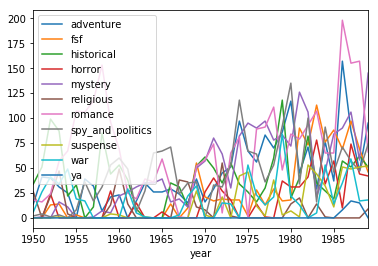

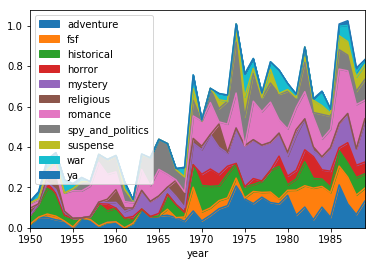

In [15]:
tall_df = pandas.DataFrame(tally_genres_binned(processed,"year")).set_index("year")
fig1 = tall_df.plot().get_figure()
fig1.savefig("eighties.png")

per_df = pandas.DataFrame(percent_genres_binned(processed,"year")).set_index("year")
fig = per_df.plot.area().get_figure()
fig.savefig("sixties_seventies_eighties_percent.png")

#tall_week_df = pandas.DataFrame(tally_genres_binned(processed,"date")).set_index("date")
#fig4 = tall_week_df.plot.area().get_figure()
#fig.savefig("by_week.png")

In [48]:
def csv_str(ls,delim):
    target = ""
    i = 0
    for x in ls:
        target = target + str(x)
        if (i == (len(ls)-1)):
            target = target + "\n"
        else:
            target = target + str(delim)
        i = i+1
    return target

def export_to_csv_for_viz(df,filename):
    ls = csv_format_arr(df)
    with open(filename, 'w') as f:
        for row in ls:
            f.write(csv_str(row,','))
    
def csv_format_arr(df):
    target = []
    for genre in per_df:
        print(genre)
        year_ls = per_df[genre]
        print type(year_ls)
        for year in year_ls.index.values:
            row = [year,genre]
            row.append(year_ls[year])
            target.append(row)
    return target

per_df
print export_to_csv_for_viz(per_df,"potatoe1s.csv") 

adventure
<class 'pandas.core.series.Series'>
fsf
<class 'pandas.core.series.Series'>
historical
<class 'pandas.core.series.Series'>
horror
<class 'pandas.core.series.Series'>
mystery
<class 'pandas.core.series.Series'>
religious
<class 'pandas.core.series.Series'>
romance
<class 'pandas.core.series.Series'>
spy_and_politics
<class 'pandas.core.series.Series'>
suspense
<class 'pandas.core.series.Series'>
war
<class 'pandas.core.series.Series'>
ya
<class 'pandas.core.series.Series'>
None


In [17]:
def books_in_genre(data,genre):
    target = set()
    for x in data:
        for f in x["fast_subjects"]:
            if genre_candidate(f) and is_genre(f,genre):
                target.add(str((x["title"],x["authors"])))
    return target

adventures = books_in_genre(processed,"adventure")
spy = books_in_genre(processed,"spy_and_politics")
war = books_in_genre(processed,"war") 
## WHERE ARE ALL THE GODDAMN WAR BOOKS? -- THERE WERE 246 ENTRIES TAGGED "WAR STORIES"
#both = adventures.intersection(spy)
both = adventures.intersection(war)

print len(war)
print len(spy)
print len(adventures)
for x in both:
    print x

39
116
122
('ICE STATION ZEBRA', ['Alistair MacLean'])
('WHIRLWIND', ['James Clavell'])
('STORM WARNING', ['Jack Higgins'])
('HORNBLOWER AND THE ATROPOS', ['C.S. Forester'])
('H.M.S. ULYSSES', ['Alistair MacLean'])
('EXOCET', ['Jack Higgins'])
('RED PHOENIX', ['Larry Bond'])
('WHERE EAGLES DARE', ['Alistair MacLean'])
('FORCE 10 FROM NAVARONE', ['Alistair MacLean'])
('TO CATCH A KING', ['Harry Patterson'])
('FLIGHT OF THE INTRUDER', ['Stephen Coonts'])


In [76]:
def percent_women_binned(cl_ls,group_val):
    df = pandas.DataFrame(cl_ls)
    grouped = df.groupby(group_val)
    target = []
    for group in grouped:
        new_row = {}
        classified = []
        index = group[0]
        g = grouped.get_group(index)
        for authors in g["genders"]:
            classified.append(class_gender(authors))
        new_row["women"] = percent_women(classified)
        new_row[group_val] = index
        target.append(new_row)
    return target

def class_gender(gender_ls):
    target = 'NA'
    for x in gender_ls:
        if x['gender'] == 'Female': ## THIS TREATS MIXED GENDER TEAMS AS FEMALE
            return 'Female'
    return 'Male'

def percent_women(class_ls):
    i = 0
    for x in class_ls:
        if x == "Female":
            i = i+1
    return float(i)/float(len(class_ls))
            
            
#for x in grouped:
#    index = x[0]
#    group = grouped.get_group(index)
#    print str(index) + str(num_titles(group))

tall_df = pandas.DataFrame(percent_women_binned(processed,"year")).set_index("year")
fig = tall_df.plot().get_figure()
fig.savefig("women1")

#fig.savefig("women2")


(1950, 'Female')


AttributeError: 'Series' object has no attribute 'get_group'

In [85]:
def unique_titles(df_ls):
    ta = set()
    ls = df_ls["title"]
    for x in ls:
        ta.add(x)
    return ta

def num_titles(ls):
    return len(unique_titles(ls))

def count_women_unweighted(ls,group_val):
    new_df = pandas.DataFrame(ls)
    new_df["genders"] = new_df["genders"].apply(class_gender)
    target = []
    grouped =  new_df.groupby([group_val,"genders"]).apply(num_titles)
    for index in grouped.index.values:
        new_row = {}
        new_row["year"] = index[0]
        gender = index[1]
        if gender == "Female":
            new_row["Female"] = grouped[index]
            new_row["Male"] = 0
        else:
            new_row["Male"] = grouped[index]
            new_row["Female"] = 0
        target.append(new_row)
    return target
            
df = pandas.DataFrame(count_women_unweighted(processed,"year")).set_index("year")
df

,Female,Male
year,,
1950,16,0
1950,0,66
1951,19,0
1951,0,79
1952,22,0
1952,0,66
1953,13,0
1953,0,64
1954,11,0


{'COME POUR THE WINE,  $12.95.) A': 'COME POUR THE WINE', 'THE CRADLE WILL FALL,  $10.95.) A': 'THE CRADLE WILL FALL', 'Norman Mailler': 'Norman Mailer', 'THE TENTH COMMANDMENT,  $11.95.) A': 'THE TENTH COMMANDMENT', 'THE SECOND COMING,  $12.95.) A': 'THE SECOND COMING'}
